In [1]:
%load_ext autoreload
%autoreload 2
import gc
import re
import pandas as pd
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 200)
import os
import sys
HOME = os.path.expanduser("~")
sys.path.append(f'{HOME}/kaggle/data_analysis/library')
import utils
import datetime

os.listdir('../input/')
key = 'card_id'
target = 'target'
ignore_list = [key, target, 'merchant_id', 'first_avtive_month']

100%|██████████| 3/3 [00:00<00:00, 28.48it/s]


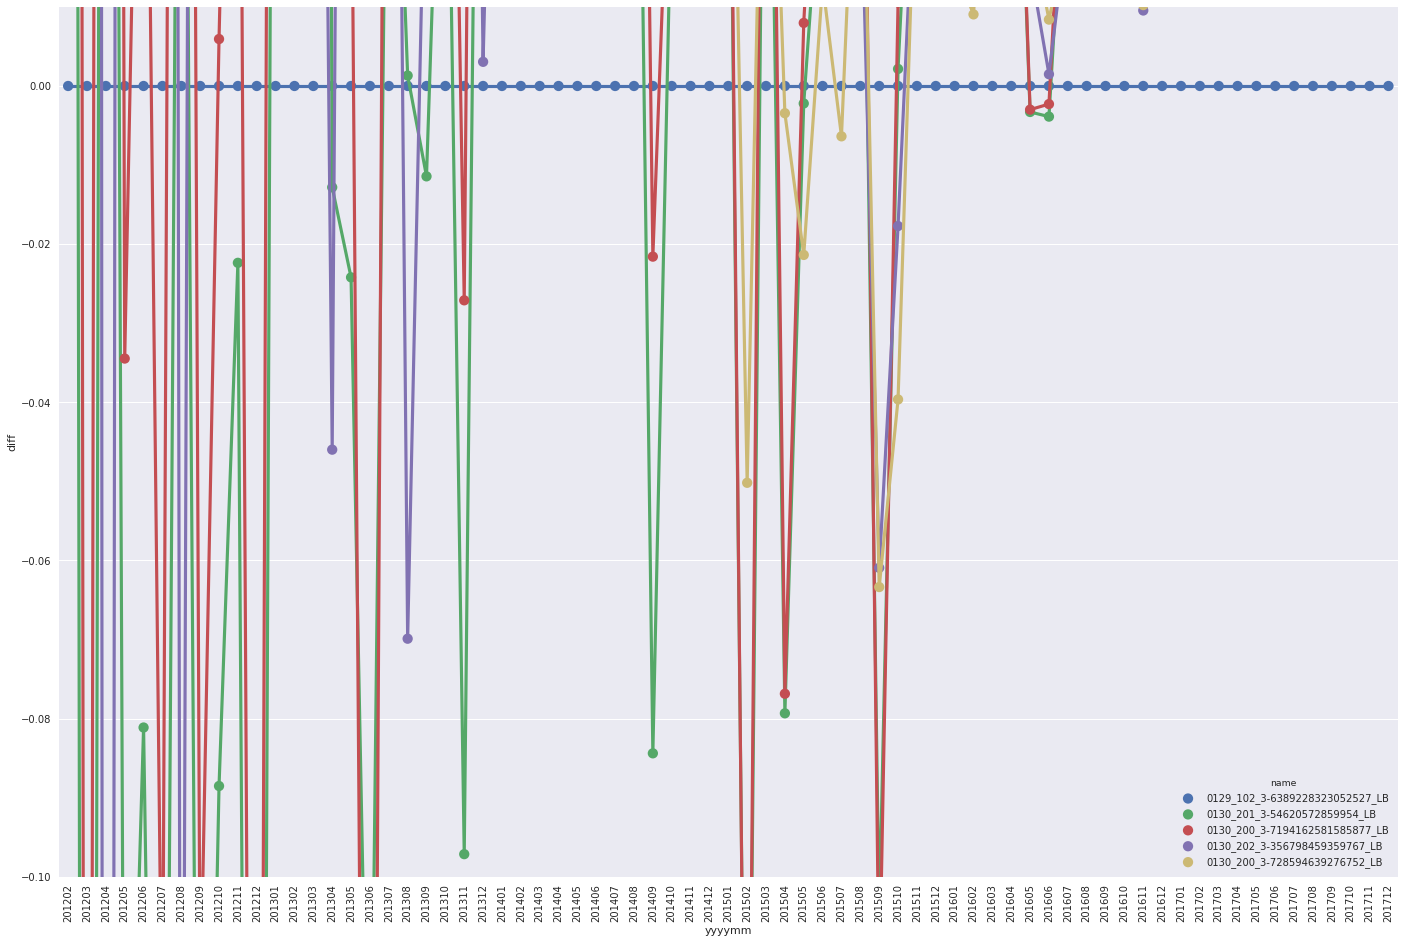

In [4]:
#========================================================================
# Result Check
#========================================================================

import glob
from joblib import Parallel, delayed

path_list = glob.glob('../stack/0130_20*.gz') + ['../stack/0129_102_stack_lgb_lr0.01_172feats_10seed_48leaves_iter992_OUT30.0965_CV3-6389228323052527_LB.gz']
# path_list = glob.glob('../stack/*.gz')
base = utils.read_df_pkl('../input/base_first*0*').set_index(key)
base['first_active_month'].fillna('2017-3', inplace=True)

def concat_stack(path):
    tmp = utils.read_pkl_gzip(path).set_index(key)
    date = re.search(r'/([^/.]*)_stack', path).group(1)
    cv = re.search(r'CV([^/.]*)', path).group(1)
    if 'pred_mean' in tmp.columns:
        tmp = tmp['pred_mean']
        tmp.name =  f"{date}_{cv}"
    else:
        tmp = tmp['prediction']
        tmp.name =  f"{date}_{cv}"
    return tmp

pred_list = Parallel(n_jobs=-1)([delayed(concat_stack)(path) for path in path_list])
df_pred = pd.concat(pred_list, axis=1)
base = base.join(df_pred)

pd.set_option('max_rows', 200)
from sklearn.metrics import mean_squared_error
#========================================================================
# Part of card_id Score

pred_cols = [col for col in base.columns if col not in ignore_list and col.count('LB')]

def get_fam_score(pred_col):

    viz_base = base[~base[target].isnull()].reset_index().fillna(0)

    part_score_list = []
    part_N_list = []
    fam_list = []
    score_list = []

    for i in range(201101, 201713, 1):
        if i%100>12:
            continue
    # for i in range(201601, 201713, 1):
        fam = str(i)[:4] + '-' + str(i)[-2:]
        df_part = viz_base[viz_base['first_active_month']==fam]
        if len(df_part)==0:
            continue
        part_id_list = df_part[key].values
    
        part_train = viz_base.loc[viz_base[key].isin(part_id_list), :]
        y_train = part_train[target].values
        
        y_pred = part_train[pred_col].values
#         y_pred = np.where(y_pred != y_pred, 0, y_pred)
        # RMSE
        part_score = np.sqrt(mean_squared_error(y_train, y_pred))

        fam_list.append(fam)
        part_score_list.append(part_score)
        part_N_list.append(len(part_id_list))
    
    df = pd.DataFrame(np.asarray([fam_list, part_score_list, part_N_list]).T)
    df.columns = ['FAM', 'CV', 'N']
    df['name'] = pred_col
    return df
    
fam_score_list = Parallel(n_jobs=-1)([delayed(get_fam_score)(pred_col) for pred_col in pred_cols])

result = pd.concat(fam_score_list, axis=0)
result['yyyymm'] = result['FAM'].map(lambda x: int(x.replace('-', '')))
result['CV'] = result['CV'].astype('float64')
result = result[result['name']!='0109_223_1-5465657344282366_LB']
result.sort_values(by=['FAM', 'CV'], ascending=True, inplace=True)
df_row = utils.row_number(df=result, level='FAM')
df_row.head()


viz_fam_min = '2012-01'
bench = df_row[df_row['name']=='0129_102_3-6389228323052527_LB']
bench = bench[bench['FAM']>=viz_fam_min]
bench['row_no'] = 'bench'
viz = df_row[df_row['row_no']<=10]
viz = viz[viz['FAM']>=viz_fam_min]
# viz = pd.concat([bench, viz], axis=0, ignore_index=True)

bench.rename(columns={'CV':'bench', 'name':'bench_name'}, inplace=True)
viz = viz.merge(bench, how='inner', on=['FAM', 'yyyymm'])
viz['diff'] = viz['CV'] - viz['bench']

plt.figure(figsize=(24, 16))
# sns.pointplot(x="yyyymm", y="CV", hue="name", data=viz)
sns.pointplot(x="yyyymm", y="diff", hue="name", data=viz)
plt.xticks(rotation=90)
plt.ylim([-0.1, 0.01])
plt.show()

In [21]:
import shutil

path_list = glob.glob('../stack/*.gz')
for p in path_list:
    tmp = utils.read_pkl_gzip(p)
    pred_cols = [col for col in tmp.columns if col.count('pred_mean') or col=='prediction']
    for col in pred_cols:
        try:
            length = tmp[tmp[col].isnull()].shape[0]
            if length>0:
                print(p)
                print(col)
                shutil.move(p, '../stack/delete/')
        except ValueError:
            print(p)
            display(tmp.head())
            sys.exit()